## How well do volunteers do against the aggregate model?

Note this requires the `volunteer_skill_exploration.ipynb` notebook to have been on each `subject_id` and the output notebooks to be saved to `/volunteer_losses`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gzbuilder_analysis.parsing import unmake_json
from gzbuilder_analysis.fitting import Model, loss
import lib.galaxy_utilities as gu
import scrapbook as sb

In [3]:
fitted_models = pd.read_pickle('lib/fitted_models.pickle')

In [4]:
agg_losses = fitted_models.agg_loss

In [5]:
nbs = sb.read_notebooks('output_files/volunteer_losses')
loss_df = pd.concat([
  pd.Series(d.get('losses', np.nan)).rename(d.get('subject_id', np.nan))
  for d in (j.scraps.data_dict for i, j in nbs.items())
], axis=1).T

In [6]:
p_better_than_agg = pd.Series([])
for name in loss_df.columns:
  res = loss_df[name].dropna()
  if len(res) > 0:
    better = (res - agg_losses.reindex(res.index) < 0)
    p_better_than_agg.loc[name] = (better < 0).astype(int).sum() / len(res)

$$\mathrm{Ability} = \beta(1 + N_\mathrm{better}, 1 + N_\mathrm{classifications} - N_\mathrm{better})$$

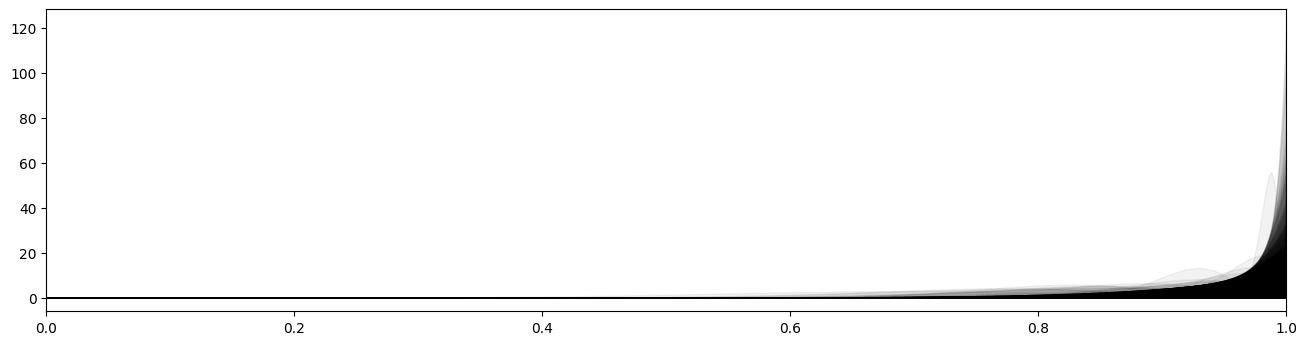

In [7]:
x = np.linspace(0, 1, 500)
five_percentile = pd.Series([])
ninety_five_percentile = pd.Series([])
means = pd.Series([])
medians = pd.Series([])
plt.figure(figsize=(16, 4), dpi=100)
for name in loss_df.columns:
  res = loss_df[name].dropna()
  if len(res) >= 10:
    better = (res - agg_losses.reindex(res.index) < 0)
    dist = st.beta.pdf(x, 1 + better.sum(), 1 + len(res) - better.sum())
    rvs = st.beta.rvs(1 + better.sum(), 1 + len(res) - better.sum(), size=10000)
    dist_median = st.beta.median(1 + better.sum(), 1 + len(res) - better.sum())
    medians.loc[name] = st.beta.median(1 + better.sum(), 1 + len(res) - better.sum())
    means.loc[name] = st.beta.mean(1 + better.sum(), 1 + len(res) - better.sum())
    five_percentile.loc[name] = np.percentile(rvs, 5)
    ninety_five_percentile.loc[name] = np.percentile(rvs, 95)
    plt.fill_between(x, 0, dist, alpha=0.05, color='k')
plt.xlim(0, 1);

20901992.0    True
20901995.0    True
20901997.0    True
20902000.0    True
20902009.0    True
20902012.0    True
20902017.0    True
20902021.0    True
20902022.0    True
20902023.0    True
20902025.0    True
20902035.0    True
20902040.0    True
20902044.0    True
21686585.0    True
dtype: bool
20901996.0    True
20902007.0    True
20902009.0    True
20902013.0    True
20902018.0    True
20902020.0    True
20902021.0    True
20902022.0    True
20902023.0    True
20902027.0    True
20902032.0    True
20902037.0    True
20902038.0    True
20902039.0    True
20902045.0    True
20902065.0    True
20902075.0    True
21096791.0    True
21096804.0    True
21096824.0    True
21096833.0    True
21096857.0    True
21096860.0    True
21096874.0    True
21096902.0    True
21096952.0    True
21096994.0    True
21686495.0    True
21686500.0    True
21686501.0    True
21686508.0    True
21686521.0    True
21686532.0    True
21686548.0    True
21686549.0    True
21686554.0    True
21686561.0    True


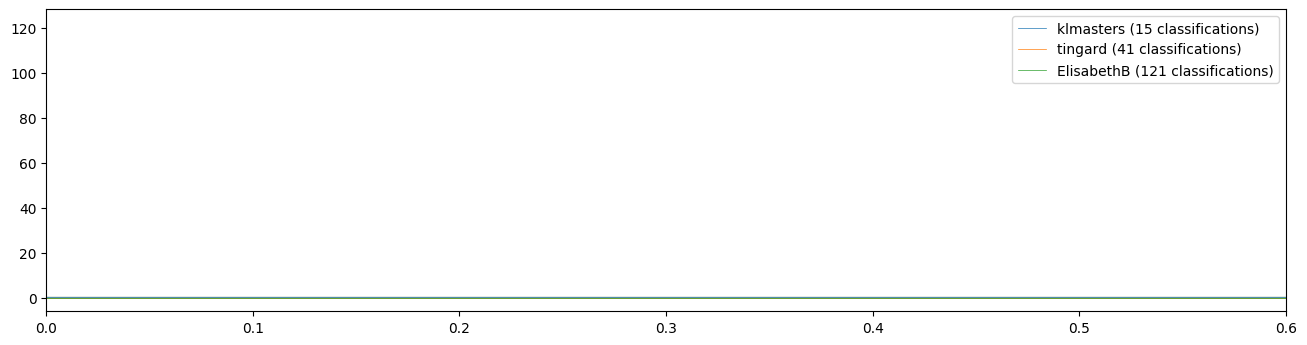

In [13]:
plt.figure(figsize=(16, 4), dpi=100)
for i, name in enumerate(('klmasters', 'tingard', 'ElisabethB')):
  res = loss_df[name].dropna()
  c = 'C{}'.format(i)
  better = (res - agg_losses.reindex(res.index) < 0)
  dist = st.beta.pdf(x, 1 + better.sum(), 1 + len(res) - better.sum())
  plt.fill_between(x, 0, dist, alpha=0.2, color=c)
  plt.plot(x, dist, c, linewidth=0.5, alpha=1, label='{} ({} classifications)'.format(name, len(res)))
plt.legend()
plt.xlim(0, 0.6);

## Upper 95% confidence bound

What are the upper bounds for volunteers that we are 95% sure they will perform worse than?

In [9]:
ninety_five_percentile.sort_values(ascending=False).head()

equidad1       0.999570
ElisabethB     0.999567
acapirala      0.999492
pangeli5       0.999474
jnarayanbvg    0.999359
dtype: float64

count    197.000000
mean       0.992686
std        0.017608
min        0.864697
25%        0.995509
50%        0.996382
75%        0.997846
max        0.999570
dtype: float64

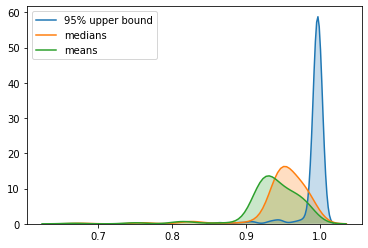

In [10]:
sns.kdeplot(ninety_five_percentile, shade=True, label='95% upper bound')
sns.kdeplot(medians, shade=True, label='medians')
sns.kdeplot(means, shade=True, label='means')
ninety_five_percentile.describe()

So what does this all mean? It means that the tuned best individual model consistently outperforms the tuned aggregate (around 70% of the time). However, for any individual volunteer, we can say with greater than 95% confidence that their raw model will be worse than the tuned aggregate model more than half the time. 